# Notebooks - Análisis exploratorio (EDA)


Hola amigos de youtube, en el siguiente vídeo les voy a hablar acerca de Notebooks. Luego, un caso puntual de análisis en Jupyter Notebooks

# Markdown 1
## Markdown 2
### Markdown 3
#### Markdown 4
##### Markdown 5

<img src='https://miro.medium.com/max/1400/1*RQBY0LUv-ItFuhJujhjkUg.png' align="...">

# Empecemos

## Cargamos librerías para usar

In [2]:

from IPython.display import HTML
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn import linear_model
import seaborn as sns
import jedi
# sns.set(style="ticks")
import datetime as dt
import plotly.express as px

%matplotlib inline
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

C:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Cargamos la data

In [3]:
FF = pd.read_csv(r"C:\Users\AR032308\Aerolineas Argentinas\PEC - Documentos\Skybreathe - MyFuelCoach\Advanced trajectory add-on\FL y Speed\BDD - waypoints completo OK.csv", encoding='ANSI', sep=';' , thousands='.', decimal=',')
print(FF.shape)
FF.head()

(769829, 21)


,Flight reference ID,Aircraft registration,Scheduled leg,Waypoint planned flight phase,Waypoint index,Waypoint name,TAKEOFF TOW [AVG],Waypoint actual trip fuel burn [AVG],Waypoint actual distance [AVG],Waypoint actual flight time [AVG],Waypoint actual flight level [AVG],Waypoint actual ground speed [AVG],Waypoint actual headwind [AVG],Waypoint actual true air speed [AVG],Waypoint actual fuel burn from previous [AVG],Waypoint actual time from previous [AVG],Waypoint actual weight,Segmento fuel flow,Segmento flight level,Segmento actual weight,Segmento actual TAS
0,70360,LVGKS,AEP-SLA,CLIMB,1,SABE,63351.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,70360,LVGKS,AEP-SLA,CLIMB,2,EZE19,63351.0,0.0,0.0,0,151.0,381.0,-15.0,366.0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,70360,LVGKS,AEP-SLA,CLIMB,3,EZE20,63351.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,70360,LVGKS,AEP-SLA,CLIMB,4,BIVAM,63351.0,351.0,25.0,4,247.0,405.0,15.0,420.0,NaN,0,63000.0,NaN,NaN,NaN,NaN
4,70360,LVGKS,AEP-SLA,CRUISE,5,TOC,63351.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


## Renombramos columnas y elegimos sólo las que vamos a utilizar


In [4]:
FF = FF.rename(columns = {'Waypoint planned flight phase': 'fase',
                          'Flight reference ID': 'ID',
                          'Aircraft registration': 'matricula',
                          'Scheduled leg': 'ruta',
                          'Waypoint name': 'wp',
                          'Segmento fuel flow':'fuel_flow',
                          'Segmento flight level' :'FL',
                          'Segmento actual weight':'weight',
                          'Segmento actual TAS':'TAS'})
df = FF[['ID', 
        'fase', 
        'matricula', 
        'ruta', 
        'wp', 
        'fuel_flow', 
        'FL', 
        'weight', 
        'TAS']]

df.head()

,ID,fase,matricula,ruta,wp,fuel_flow,FL,weight,TAS
0,70360,CLIMB,LVGKS,AEP-SLA,SABE,NaN,NaN,NaN,NaN
1,70360,CLIMB,LVGKS,AEP-SLA,EZE19,NaN,NaN,NaN,NaN
2,70360,CLIMB,LVGKS,AEP-SLA,EZE20,NaN,NaN,NaN,NaN
3,70360,CLIMB,LVGKS,AEP-SLA,BIVAM,NaN,NaN,NaN,NaN
4,70360,CRUISE,LVGKS,AEP-SLA,TOC,NaN,NaN,NaN,NaN


## Nos quedamos con fase crucero

Sólo nos interesa la fase de crucero para este análisis. 
Descartamos TOC porque al comparar con tramo anterior, contiene en verdad fuel flow de climb

In [5]:
df = df[(df.fase == 'CRUISE') & 
               (FF.wp!= 'TOC')]


filas_previas = df.shape[0]

df.shape

(337016, 9)

## Buscamos NAs

Una forma fácil de buscar NAs es con un heatmap de nulos. 
Esto nos permite ver rápidamente dónde están los NAs: 
- concentraros por columna
- distribuídos en filas


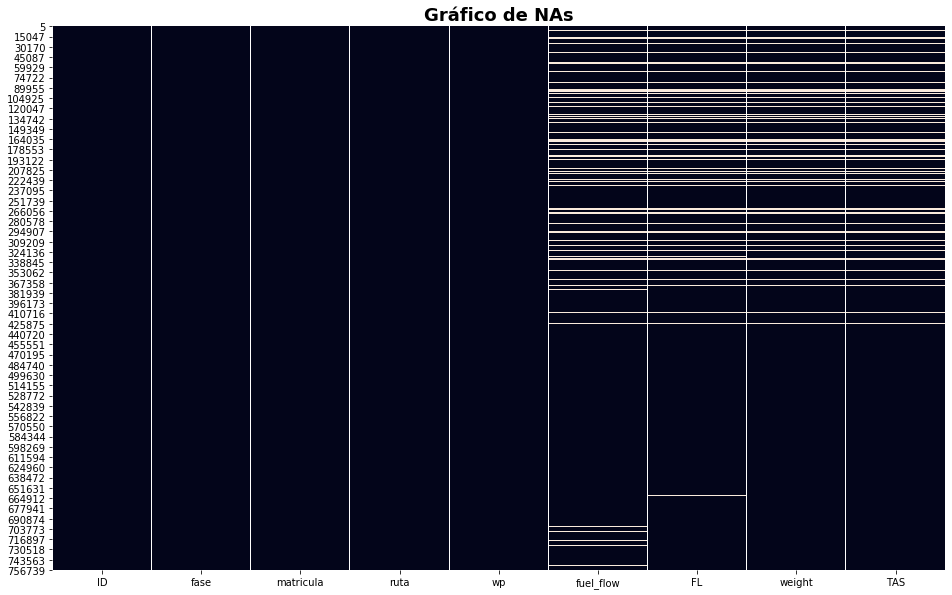

In [6]:
plt.figure(figsize=(16,10))

sns.heatmap(df.isnull(), cbar=False)
plt.title('Gráfico de NAs', fontsize=18, fontweight='bold');

## Análisis de NAs

Vemos que en este caso los NAs están se repiten para todas las columnas de data (salvo pocas excepciones). 
Podemos tirar los NAs entonce. Si por ejemplo estarían concentrados en alguna columna, deberíamos ver 
si existe un problema con la base de datos

In [7]:

df = df.dropna(subset = ['fuel_flow', 
                                      'FL', 
                                      'weight', 
                                      'TAS'])
filas_nuevas = df.shape[0]

print('Filas previas: {}'.format(filas_previas))
print('Filas nuevas: {}'.format(filas_nuevas))
print('Se eliminó el {:.3} % de las filas'.format( (1- filas_nuevas/filas_previas)*100 ))

Filas previas: 337016
Filas nuevas: 293834
Se eliminó el 12.8 % de las filas


In [ ]:
plt.figure(figsize=(16,10))

sns.heatmap(df.isnull(), cbar=False)
plt.title('Gráfico post drop NAs', fontsize=18, fontweight='bold');

In [ ]:
df.info()

## Reorganizamos la data:
- Pasamos FL a valores redondeados


In [ ]:
df['FL_round'] = df['FL']/10

df['FL_round'] = df['FL_round'].round(decimals = 0).astype(int)*10


df.head()

In [ ]:
df['par'] = df.FL_round/10 % 2 == 0

df.head()

In [ ]:
df['ID'] = df['ID'].apply(lambda x: str(int(x)))
df['FL_round'] = df['FL_round'].apply(lambda x: str(int(x)));

print("# de vuelos:", len(df.ID.unique()))

# Analizamos fuel_flow

Vemos nuestra variable target. El objetivo es encontrar outliers y entender patrones de variación


In [ ]:
plt.figure(figsize=(16,6))

ax = sns.boxplot(data = df, x = 'fuel_flow')

plt.title('FUEL FLOW', fontsize=18, fontweight='bold');

In [ ]:
plt.figure(figsize=(16,6))

ax =sns.distplot(df['fuel_flow']);

plt.title('Fuel flow', fontsize=18, fontweight='bold');

## Vemos que valores de fuel flow extremos son anormales: 
- Valores bajos: tengamos computados casos de descenso como cruise
- Valores muy altos: tengamos computados casos de climb como cruise

In [ ]:
df =df[ (df.fuel_flow>1600)  & (df.fuel_flow<3000)]
df.head()

In [ ]:
plt.figure(figsize=(16,30))

ax = sns.boxplot(data = df, x = 'fuel_flow', y = 'ruta')

plt.title('FUEL FLOW - ruta', fontsize=18, fontweight='bold');


In [ ]:
plt.figure(figsize=(16,10))

ax = sns.boxplot(data = df, x = 'fuel_flow', y = 'matricula')

plt.title('FUEL FLOW - matricula ', fontsize=18, fontweight='bold');

In [ ]:
plt.figure(figsize=(16,10))

ax = sns.boxplot(data = df, x = 'weight', y = 'matricula')

plt.title('Weight - Matricula', fontsize=18, fontweight='bold');

### Eliminamos valores de weight: 
- menores a 40.000
- mayores a 80.000



In [ ]:
plt.figure(figsize=(16,6))

ax =sns.distplot(df['weight']);

plt.title('weight con outliers', fontsize=18, fontweight='bold');

In [ ]:
df =df[ (df.weight>50000)  & (df.weight<72000)]
df

In [ ]:
plt.figure(figsize=(16,6))

ax =sns.kdeplot(df['weight'], shade=True);

plt.title('weight post outliers', fontsize=18, fontweight='bold');

### Discretizamos variable weight: 

Para facilitar el análisis, hacemos discreta una variable continua. 
Es decir, asignamos una etiqueta a un valor, si el mismo se encuentra dentro de un determinado rango. 

In [ ]:
weight_label = ['1', '2', '3']#, '4', '5', '6', '7', '8', '9', '10']

df['weight_bin'] = pd.qcut(df['weight'],
                              q=3,
                              labels=weight_label)

df.head()

In [ ]:
plt.figure(figsize=(16,10))

ax = sns.boxplot(data = df, x = 'weight_bin', y = 'fuel_flow')

plt.title('Fuel Flow - weight_bin', fontsize=18, fontweight='bold');

# Analizamos TAS

Buscamos outliers y entendemos patrones

In [ ]:
plt.figure(figsize=(16,6))

ax = sns.boxplot(data = df, x = 'TAS')

plt.title('TAS boxplot', fontsize=18, fontweight='bold');

In [ ]:
plt.figure(figsize=(16,6))

ax =sns.kdeplot(df['TAS'], shade=True);

plt.title('TAS con outliers', fontsize=18, fontweight='bold');

In [ ]:
df =df[ (df.TAS>420)]
df

In [ ]:
plt.figure(figsize=(16,6))

ax =sns.distplot(df['TAS']);

plt.title('TAS post outliers', fontsize=18, fontweight='bold');

In [ ]:
TAS_label = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

df['TAS_bin'] = pd.qcut(df['TAS'],
                              q=10,
                              labels=TAS_label)

df.head()

In [ ]:
plt.figure(figsize=(16,10))

ax = sns.boxplot(data = df, x = 'TAS_bin', y = 'fuel_flow', showfliers = False)

plt.title('Fuel Flow - TAS', fontsize=18, fontweight='bold');

In [ ]:
plt.figure(figsize=(16,10))

ax = sns.boxplot(data = df, x = 'FL_round', y = 'fuel_flow', showfliers = False)

plt.title('Fuel Flow - Flight Level', fontsize=18, fontweight='bold');

In [ ]:
plt.figure(figsize=(16,6))
ax = sns.countplot(x='FL_round', data=df)

plt.title('Distribución de FL', fontsize=18, fontweight='bold')
plt.show()

                   

Sacamos los FL< 280

In [ ]:
df = df[ df['FL']>= 280]

plt.figure(figsize=(16,6))
ax = sns.countplot(x='FL_round', data=df)
plt.title('Distribución de FL > 280', fontsize=18, fontweight='bold')
plt.show()


# Hacemos una heatmap para ver cómo influyen las dos variables en fuel flow: 

- Primero tenemos disponer la data de una manera adecuada
- realizamos el mapa

In [ ]:
sns.jointplot(x=df['TAS'] ,
                   y=df['FL'], kind = 'hex', height = 16 , ratio =5)


In [ ]:
df_pivot = df.pivot_table(values = 'fuel_flow', index = 'FL_round', columns = 'TAS_bin', aggfunc = 'median')

df_pivot

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
fig.subplots_adjust(top=1.1)

cbar_kws = {'orientation':"horizontal", 'pad':0.1 , 'aspect':16}

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, weight='bold')

sns.heatmap(df_pivot,   annot = True, fmt='.1f', linewidths=.1, ax = ax,  cbar_kws = cbar_kws, cmap='RdPu' )

plt.title('Heatmap AVG fuel flow', fontsize=18, fontweight='bold');


In [ ]:
df_pivot = df.pivot_table(values = 'fuel_flow', index = 'FL_round', columns = 'TAS_bin', aggfunc = 'count')/df.fuel_flow.count()*100
df_pivot


fig, ax = plt.subplots(figsize=(16, 10))
fig.subplots_adjust(top=1.1)

cbar_kws = {'orientation':"horizontal", 'pad':0.1 , 'aspect':16}

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, weight='bold')

sns.heatmap(df_pivot,  vmin = 1, annot = True, fmt='.1f', linewidths=.1, ax = ax,  cbar_kws = cbar_kws, cmap='RdPu' )

plt.title('Heatmap % data points', fontsize=18, fontweight='bold');


Vemos que hay la concentración de datos está en FL>350 y TAS_bin<7. En 

In [ ]:
sns.catplot(y = "fuel_flow", hue = "TAS_bin", col = 'FL_round', row = 'TAS_bin',  data = df, kind = 'box', height = 10, showfliers = False);
plt.show()

# Ploteo 3D

- Ploteamos todo
- Empezamos a reducir variables para entender tendencias


In [ ]:
fig = px.scatter_3d( df, 
                    x='FL_round', y='TAS_bin', z='fuel_flow', color = 'fuel_flow', size_max=0.01)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

### Ploteamos sólo AEP-COR

In [ ]:
fig = px.scatter_3d( df[ (df['ruta']=='AEP-COR') & df.par ], 
                    x='FL_round', y='TAS_bin', z='fuel_flow', color = 'fuel_flow', size_max=0.01)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

In [ ]:
fig = px.scatter_3d(df[ ((df['FL_round']=='400')|(df['FL_round']=='360')| (df['FL_round']=='320')) 
                       & (df['TAS']>420) & (df['TAS']<480) 
                       & (df['fuel_flow']>1800)& (df['fuel_flow']<3000)
                      &  (df['ruta']=='AEP-COR') ], 
                    
                    x='FL_round', y='TAS_bin', z='fuel_flow', color = 'fuel_flow', size_max=0.01
                   )

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

In [ ]:
a = df.pivot_table(values = ['fuel_flow', 'weight'], index = ['FL_round', 'TAS_bin', 'par'], aggfunc = 'median').reset_index()
a.head()

In [ ]:
fig = px.scatter_3d(a [ (a.par)] , 
                    x = 'FL_round', y = 'TAS_bin', z = 'fuel_flow', color = 'fuel_flow')

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

# Cómo afecta el peso?

### Si observamos cómo varía el peso en función de la altitud:

In [ ]:
plt.figure(figsize=(16,5))

ax = sns.boxplot(data = df, x = 'FL_round', y = 'weight', showfliers = False)

plt.title('Weight vs FL', fontsize=18, fontweight='bold');

### Vemos que altitudes mayores se alcanzan con aviones más livianos. Por lo tanto, el fuel flow observado está afectado también por un sesgo

Analizamos entonces el efecto del peso
Agregamos: 
 - weight bin al análisis

In [ ]:
b = df.pivot_table(values = ['fuel_flow', 'weight'], index = ['FL_round', 'TAS_bin', 'par', 'weight_bin'], aggfunc = 'median').reset_index()
b.head()

In [ ]:
fig = px.scatter_3d(b [ (b.par)& ((b['FL_round']=='380')|(b['FL_round']=='360')| (b['FL_round']=='320')) ] , 
                    x = 'FL_round', y = 'TAS_bin', z = 'fuel_flow', color = 'weight_bin')

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

### Si observamos sólo aviones con peso intermedio:

In [ ]:
fig = px.scatter_3d(b [ (b.par) & (b.weight_bin == '2') ] , 
                    x = 'FL_round', y = 'TAS_bin', z = 'fuel_flow', color = 'fuel_flow')

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

# RECURSOS


Tutorial Jupyter: 

- https://facundoq.github.io/courses/aa2018/res/02_python.html
- https://towardsdatascience.com/the-complete-guide-to-jupyter-notebooks-for-data-science-8ff3591f69a4


Instalar Python:
- http://facundoq.github.io/courses/images/jupyter.html

Ejemplos de notebooks piolas: 
- https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks

